# Worked All OARC

## Setup

### Imports

First we do all of our imports. Ideally we import in alphabetical order, and I wish there was a way to generate `requirements.txt` from it directly.

I also detect if running on Google Colab as I need to import from here...

In [160]:
import os

if 'COLAB_GPU' in os.environ:
    !pip install maidenhead ipyleaflet ipywidgets pyhamtools
    from google.auth import default
    from google.colab import auth

import datetime
import gspread as gs
import ipywidgets as widgets
import maidenhead as mh
import matplotlib
import pandas as pd
import re
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker, MarkerCluster, Polyline
from ipywidgets import interact, interact_manual
from matplotlib import pyplot
from pyhamtools import LookupLib, Callinfo


### Setup pyhamtools

Little bit of set up for DXCC cleaning

In [161]:
my_lookuplib = LookupLib(lookuptype='countryfile')
cic = Callinfo(my_lookuplib)

### Set up Google Sheet credentials

Some nasty little tricks needed here:

1. For local environment, we use a .json file in the parent so it won't be pushed to github
1. For Netlify deployment, we detect it by reading the Environment Variable `NETLIFY`
   1. Then we read all the env vars into a dictionary
   2. We have to replace all the `'\\n'` with `'\n'` as the extra `'\'` gets added
1. Then we get access to the Google Sheet

In [162]:
def create_keyfile_dict():
    variables_keys = {
       "type": os.getenv("TYPE"),
       "project_id": os.getenv("PROJECT_ID"),
       "private_key_id": os.getenv("PRIVATE_KEY_ID"),
       "private_key": os.getenv("PRIVATE_KEY").replace("\\n", "\n"),
       "client_email": os.getenv("CLIENT_EMAIL"),
       "client_id": os.getenv("CLIENT_ID"),
       "auth_uri": os.getenv("AUTH_URI"),
       "token_uri": os.getenv("TOKEN_URI"),
       "auth_provider_x509_cert_url": os.getenv("AUTH_PROVIDER_X509_CERT_URL"),
       "client_x509_cert_url": os.getenv("CLIENT_X509_CERT_URL")
    }
    return variables_keys
if os.environ.get('NETLIFY'):
    gc = gs.service_account_from_dict(create_keyfile_dict())
elif 'COLAB_GPU' in os.environ:
    auth.authenticate_user()
    creds, _ = default()
    gc = gs.authorize(creds)
else:
    gc = gs.service_account(filename='../workedalloarc-53ba91a71aa2.json')
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
ws = sh.worksheet('Form responses 1')
sh2 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1n6HCnGL-5z9RSuMO7bu5Un3iND_H2TEmj7brkdfnl8c/edit?usp=sharing')
ws2 = sh2.worksheet('Map')

### Load all the records

Our assumption zero is that all the data is dirty and not to be trusted. Even validation isn't perfect.
So we load it in first.

We also make a dfclean into which we will create a 'clean' set of QSOs. We will generate a series of error rows too

In [163]:
df = pd.DataFrame(ws.get_all_records())
dfclean = df.copy()
csmap = pd.DataFrame(ws2.get_all_records())
df.head(10)
csmap.head(10)

,Alias,Base Callsign
0,M0SMU,M0SMU
1,M7SMU,M0SMU
2,M0SMU/P,M0SMU
3,2E0UMS,M0SMU
4,EI5IYB,EI5IYB
5,EI5IYB/P,EI5IYB
6,MQ0JQQ,M0JQQ
7,MQ0LKW,M0LKW
8,MQ0TZO,M0TZO
9,MW0TZO,M0TZO


## Cleaning up the data

### Get all rows in scope of contest

Our start datetime is 00:00 1 June 2022 and end is 23:59 30 Sept. All UTC

In [164]:
start_date = pd.Timestamp(datetime.date(2022, 5, 31))
end_date = pd.Timestamp(datetime.date(2022,9,1))
dfclean['UTC'] = pd.to_datetime(dfclean['QSO Datetime (UTC)'], format='%d/%m/%Y %H:%M:%S')
#print(dfclean.dtypes)
mask = dfclean['UTC'] > start_date
dfclean = dfclean.loc[mask]
dfclean
#dfcleantime=dfclean[dfclean.UTC.between('2022-06-01', '2022-06-02')]
#dftime = dfclean[dfclean.UTC.between('2022-1-6', '2022-10-9')]
#dftime = dfclean.query('UTC >= @start_date and UTC < @end_date')

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,UTC
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,First!,2022-06-01 08:17:00
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,,2022-06-01 13:17:00
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,,2022-06-01 10:00:00
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,,2022-06-01 14:40:00
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,,2022-06-01 10:00:00
17,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,Via OARC Digital Bridge,,,2022-06-01 15:21:00
18,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,144 MHz (2m),Digital Voice,,,OARC Digital bridge,Using echo link via computer,,2022-06-01 15:21:00
19,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,144 MHz (2m),Digital Voice,IO86BC,IO88MX,OARC Bridge,,,2022-06-01 15:25:00
20,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,,,,2022-06-01 15:30:00
21,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,,2022-06-01 14:36:00


### Callsigns

So the first job is to clean up the callsigns, you can't have a QSO without two valid callsigns!

I've found a good regex to split out a callsign into components (prefix, letters, number, letters, suffix), but as we will see later, that isn't enough to extract the DXCC from a callsign.

In [165]:
# Next we clean the callsigns up and find any prefix / suffix and the DXCC
regex = re.compile('^([A-Z0-9]+[\/])?([A-Z][0-9]|[A-Z]{1,2}|[0-9][A-Z])([0-9]|[0-9]+)([A-Z]+)([\/][A-Z0-9]+)?')
df['Your Callsign Clean'] = df['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
df['Your Prefix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[0]
df['Your Suffix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[4]
df['Their Callsign Clean'] = df['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
df['Their Prefix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[0]
df['Their Suffix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[4]
df.head(10)


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,Your Callsign Clean,Your DXCC,Your Prefix,Your Suffix,Their Callsign Clean,Their DXCC,Their Prefix,Their Suffix
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test,M0SMU,M,NaN,NaN,M7SMU,M,NaN,NaN
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0UMS,2E,NaN,NaN
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !,2E0GGJ,2E,NaN,NaN,M0NVK,M,NaN,NaN
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,,MOJQQ,NaN,NaN,NaN,M0LTE,M,NaN,NaN
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,,M0JQQ,M,NaN,NaN,M0SMU,M,NaN,NaN
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0VCC/P,2E,NaN,/P
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details,EI5IYB/P,EI,NaN,/P,M0SMU,M,NaN,NaN
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,,2E0UMS,2E,NaN,NaN,M0OUK,M,NaN,NaN
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,,EI5IYB,EI,NaN,NaN,TF2MSN,TF,NaN,NaN
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,,EI5IYB,EI,NaN,NaN,IW9FRA,IW,NaN,NaN


### Clean up callsigns in dfclean

Remove suffix and have suffix in another column (My Suffix, Their Suffix)

In [166]:
dfclean['Your Callsign'] = dfclean['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Your Prefix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[0]
dfclean['Your Suffix'] = dfclean['Your Callsign'].str.extract(regex, expand=True)[4]
dfclean['Their Callsign'] = dfclean['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
#df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
dfclean['Their Prefix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[0]
dfclean['Their Suffix'] = dfclean['Their Callsign'].str.extract(regex, expand=True)[4]
dfclean.head(10)

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,UTC,Your Prefix,Your Suffix,Their Prefix,Their Suffix
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,First!,2022-06-01 08:17:00,NaN,NaN,NaN,NaN
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,,2022-06-01 13:17:00,NaN,NaN,NaN,NaN
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,,2022-06-01 10:00:00,NaN,NaN,NaN,NaN
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,,2022-06-01 14:40:00,NaN,NaN,NaN,NaN
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,,2022-06-01 10:00:00,NaN,NaN,NaN,NaN
17,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,Via OARC Digital Bridge,,,2022-06-01 15:21:00,NaN,NaN,NaN,NaN
18,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,144 MHz (2m),Digital Voice,,,OARC Digital bridge,Using echo link via computer,,2022-06-01 15:21:00,NaN,NaN,NaN,NaN
19,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,144 MHz (2m),Digital Voice,IO86BC,IO88MX,OARC Bridge,,,2022-06-01 15:25:00,NaN,NaN,NaN,NaN
20,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,,,,2022-06-01 15:30:00,NaN,NaN,NaN,NaN
21,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,,2022-06-01 14:36:00,NaN,NaN,NaN,NaN


### Clean DXCC

We want to extract the DXCC for dfclean callsigns

In [167]:
def cleandxcc(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_country_name(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def cleanituz(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_ituz(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def cleancqz(callsign):
    '''returns the DXCC for a callsign'''
    try:
        ret = cic.get_cqz(callsign)
    except KeyError:
        ret = "N/A"
    return ret

def homecallsign(callsign):
    '''returns home callsign and strips prefix / suffix'''
    try:
        ret = cic.get_homecall(callsign)
    except KeyError:
        ret = 'N/A'
    return ret

print(cleandxcc('IW9AAB'))
print(cleandxcc('M7SMU'))
print(cleandxcc('EI5IYB/P'))
print(cleandxcc('MQ0JQQ'))
print(cic.is_valid_callsign('MQ0JQQ'))
print(cic.get_homecall('MW0TZO/P'))

dfclean['Your DXCC'] = dfclean['Your Callsign'].map(lambda x: cleandxcc(x))
dfclean['Their DXCC'] = dfclean['Their Callsign'].map(lambda x: cleandxcc(x))
dfclean['Your ITUZ'] = dfclean['Your Callsign'].map(lambda x: cleanituz(x))
dfclean['Their ITUZ'] = dfclean['Their Callsign'].map(lambda x: cleanituz(x))
dfclean['Your CQZ'] = dfclean['Your Callsign'].map(lambda x: cleancqz(x))
dfclean['Their CQZ'] = dfclean['Their Callsign'].map(lambda x: cleancqz(x))

dfclean

Sicily
England
Ireland
England
True
MW0TZO


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Your Prefix,Your Suffix,Their Prefix,Their Suffix,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ
12,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
13,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
14,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,NaN,NaN,NaN,NaN,England,Scotland,27,27,14,14
15,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14
16,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,NaN,NaN,NaN,NaN,Scotland,England,27,27,14,14
17,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,Via OARC Digital Bridge,,...,NaN,NaN,NaN,NaN,England,Scotland,27,27,14,14
18,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,144 MHz (2m),Digital Voice,,,OARC Digital bridge,Using echo link via computer,...,NaN,NaN,NaN,NaN,Scotland,England,27,27,14,14
19,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,144 MHz (2m),Digital Voice,IO86BC,IO88MX,OARC Bridge,,...,NaN,NaN,NaN,NaN,Scotland,Scotland,27,27,14,14
20,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,,,...,NaN,NaN,NaN,NaN,Scotland,Scotland,27,27,14,14
21,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,...,NaN,NaN,NaN,NaN,England,England,27,27,14,14


### Map aliases to base callsigns

In [168]:
dfclean['Your Home Callsign'] = dfclean['Your Callsign'].map(lambda x: homecallsign(x))
dfcleanalised = pd.merge(left=dfclean, right=csmap, left_on='Your Home Callsign', right_on='Alias', how='left')
dfcleanalised['Base Your Callsign'] = dfcleanalised['Base Callsign'].combine_first(dfcleanalised['Your Callsign'])
dfcleanalised = dfcleanalised.drop(['Base Callsign', 'Alias'], axis=1)
dfcleanalised

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Their Prefix,Their Suffix,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ,Your Home Callsign,Base Your Callsign
0,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,NaN,NaN,England,England,27,27,14,14,M0SMU,M0SMU
1,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,NaN,NaN,England,England,27,27,14,14,MQ0LKW,M0LKW
2,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,NaN,NaN,England,Scotland,27,27,14,14,MQ0LKW,M0LKW
3,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,NaN,NaN,England,England,27,27,14,14,M0SMU,M0SMU
4,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,NaN,NaN,Scotland,England,27,27,14,14,2M0IIG,2M0IIG
5,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,Via OARC Digital Bridge,,...,NaN,NaN,England,Scotland,27,27,14,14,M0SMU,M0SMU
6,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,144 MHz (2m),Digital Voice,,,OARC Digital bridge,Using echo link via computer,...,NaN,NaN,Scotland,England,27,27,14,14,2M0OCC,2M0OCC
7,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,144 MHz (2m),Digital Voice,IO86BC,IO88MX,OARC Bridge,,...,NaN,NaN,Scotland,Scotland,27,27,14,14,2M0OCC,2M0OCC
8,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,,,...,NaN,NaN,Scotland,Scotland,27,27,14,14,2M0PVP,2M0PVP
9,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,...,NaN,NaN,England,England,27,27,14,14,M0LTE,M0LTE


In [169]:
dfcleanalised['Their Home Callsign'] = dfcleanalised['Their Callsign'].map(lambda x: homecallsign(x))
dfcleanalised = pd.merge(left=dfcleanalised, right=csmap, left_on='Their Home Callsign', right_on='Alias', how='left')
dfcleanalised['Base Their Callsign'] = dfcleanalised['Base Callsign'].combine_first(dfcleanalised['Their Home Callsign'])
dfcleanalised = dfcleanalised.drop(['Base Callsign', 'Alias'], axis=1)
dfcleanalised

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,...,Your DXCC,Their DXCC,Your ITUZ,Their ITUZ,Your CQZ,Their CQZ,Your Home Callsign,Base Your Callsign,Their Home Callsign,Base Their Callsign
0,01/06/2022 09:18:10,01/06/2022 08:17:00,M0SMU,MQ0JQQ,430 MHz (70cms),Digital Voice,,,OARC Digital Bridge,DMR -> UHF -> Hotspot -> Internet -> OARC Digi...,...,England,England,27,27,14,14,M0SMU,M0SMU,MQ0JQQ,M0JQQ
1,01/06/2022 14:26:12,01/06/2022 13:17:00,MQ0LKW,MQ0JQQ,7 MHz (40m),FT8,JO01,IO95,,,...,England,England,27,27,14,14,MQ0LKW,M0LKW,MQ0JQQ,M0JQQ
2,01/06/2022 14:27:10,01/06/2022 10:00:00,MQ0LKW,2M0IIG,7 MHz (40m),FT8,JO01,IO85,,,...,England,Scotland,27,27,14,14,MQ0LKW,M0LKW,2M0IIG,2M0IIG
3,01/06/2022 15:45:24,01/06/2022 14:40:00,M0SMU,M0LTE,Discord,FT8,IO81,IO91,,FT8 via M4a / MP3 over Discord (Audacity / VLC...,...,England,England,27,27,14,14,M0SMU,M0SMU,M0LTE,M0LTE
4,01/06/2022 15:46:28,01/06/2022 10:00:00,2M0IIG,MQ0LKW,7 MHz (40m),FT8,IO85,JO01,,,...,Scotland,England,27,27,14,14,2M0IIG,2M0IIG,MQ0LKW,M0LKW
5,01/06/2022 16:22:16,01/06/2022 15:21:00,M0SMU,2M0OCC,430 MHz (70cms),Digital Voice,,,Via OARC Digital Bridge,,...,England,Scotland,27,27,14,14,M0SMU,M0SMU,2M0OCC,2M0OCC
6,01/06/2022 16:27:48,01/06/2022 15:21:00,2M0OCC,M0SMU,144 MHz (2m),Digital Voice,,,OARC Digital bridge,Using echo link via computer,...,Scotland,England,27,27,14,14,2M0OCC,2M0OCC,M0SMU,M0SMU
7,01/06/2022 16:30:43,01/06/2022 15:25:00,2M0OCC,2M0PVP,144 MHz (2m),Digital Voice,IO86BC,IO88MX,OARC Bridge,,...,Scotland,Scotland,27,27,14,14,2M0OCC,2M0OCC,2M0PVP,2M0PVP
8,01/06/2022 16:31:52,01/06/2022 15:30:00,2M0PVP,2M0OCC,430 MHz (70cms),Digital Voice,IO88MX,IO86BC,,,...,Scotland,Scotland,27,27,14,14,2M0PVP,2M0PVP,2M0OCC,2M0OCC
9,01/06/2022 18:14:37,01/06/2022 14:36:00,M0LTE,M0SMU,Discord,FT8,IO91,IO81,,FT8 via acoustically coupled voice notes sent ...,...,England,England,27,27,14,14,M0LTE,M0LTE,M0SMU,M0SMU


## Example Leaderboards

### Most QSOs made

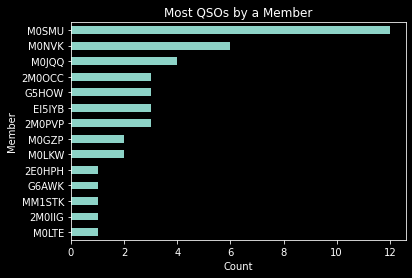

In [170]:
from matplotlib.ticker import MaxNLocator

with pyplot.style.context(('dark_background')):
    mostworked = dfcleanalised['Base Your Callsign'].value_counts().sort_values().plot.barh()
    mostworked.set_title('Most QSOs by a Member')
    mostworked.set_xlabel('Count')
    mostworked.set_ylabel('Member')
    mostworked.xaxis.set_major_locator(MaxNLocator(integer=True))

### Most members worked

How many individual members have been worked?

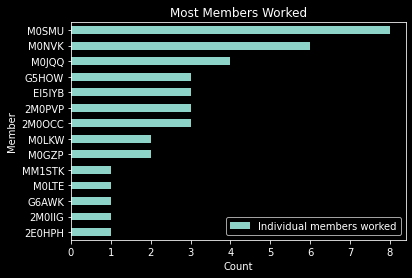

In [171]:
with pyplot.style.context(('dark_background')):
    mostmemworked = dfcleanalised[['Base Your Callsign','Base Their Callsign']]
    mostmemworked = mostmemworked.drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Base Their Callsign').plot.barh()
    mostmemworked.set_xlabel('Count')
    mostmemworked.set_title('Most Members Worked')
    mostmemworked.set_ylabel('Member')
    mostmemworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostmemworked.legend(['Individual members worked'])

### Worked by most Members

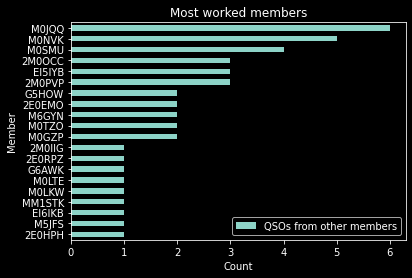

In [172]:
with pyplot.style.context(('dark_background')):
    workedmost = dfcleanalised['Base Their Callsign'].value_counts().sort_values().plot.barh()
    workedmost.set_title('Most worked members')
    workedmost.set_xlabel('Count')
    workedmost.set_ylabel('Member')
    workedmost.xaxis.set_major_locator(MaxNLocator(integer=True))
    workedmost.legend(['QSOs from other members'])

### Most DXCC worked

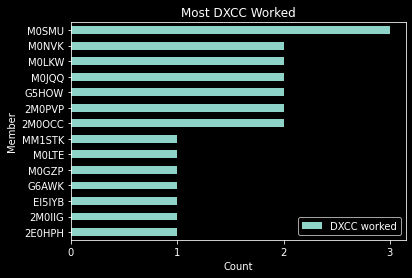

In [173]:
with pyplot.style.context(('dark_background')):
    mostdxccworked = dfcleanalised[['Base Your Callsign','Their DXCC']]
    mostdxccworked = mostdxccworked.drop_duplicates().groupby('Base Your Callsign').count().sort_values(by='Their DXCC').plot.barh()
    mostdxccworked.set_xlabel('Count')
    mostdxccworked.set_title('Most DXCC Worked')
    mostdxccworked.set_ylabel('Member')
    mostdxccworked.xaxis.set_major_locator(MaxNLocator(integer=True))
    mostdxccworked.legend(['DXCC worked'])

## Example interaction

### Show 'my' QSOs

Note this is disabled in Netlify (as it doesn't work...)

In [174]:
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_my_QSO(Callsign = dfcleanalised['Base Your Callsign'].unique()):
        return dfcleanalised.loc[dfcleanalised['Base Your Callsign'].values==Callsign]

interactive(children=(Dropdown(description='Callsign', options=('M0SMU', 'M0LKW', '2M0IIG', '2M0OCC', '2M0PVP'…

### Show QSOs by Band and Mode

In [175]:
print(dfcleanalised['Band'].unique())
print(dfcleanalised['Mode'].unique())
if os.environ.get('NETLIFY'):
    print("Sadly we can't do interactivity in Netlify environment - I need to find a work around")
else:
    @interact
    def show_by_band_mode(Band = dfcleanalised['Band'].unique(), Mode = dfcleanalised['Mode'].unique()):
        return dfcleanalised.loc[(dfcleanalised['Band'].values==Band) & (dfcleanalised['Mode'].values==Mode)]

['430 MHz (70cms)' '7 MHz (40m)' 'Discord' '144 MHz (2m)'
 'Echolink via Echoham' 'Satellite (SO50)' '14 MHz (20m)']
['Digital Voice' 'FT8' 'SSB' 'FM' 'SSTV']


interactive(children=(Dropdown(description='Band', options=('430 MHz (70cms)', '7 MHz (40m)', 'Discord', '144 …

## Plotting some graphs

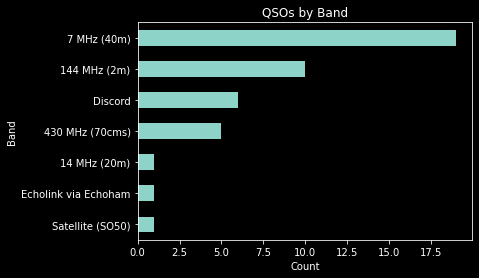

In [176]:
with pyplot.style.context(('dark_background')):
    bandplot = dfcleanalised['Band'].value_counts().sort_values().plot.barh()
    bandplot.set_title('QSOs by Band')
    bandplot.set_xlabel('Count')
    bandplot.set_ylabel('Band')

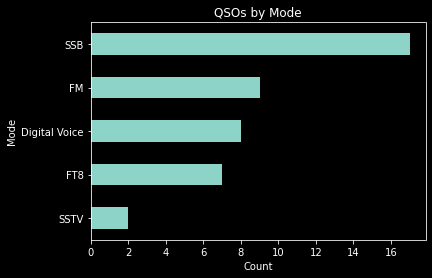

In [177]:
with pyplot.style.context(('dark_background')):
    modeplot = dfcleanalised['Mode'].value_counts().sort_values().plot.barh()
    modeplot.set_title('QSOs by Mode')
    modeplot.set_xlabel('Count')
    modeplot.set_ylabel('Mode')

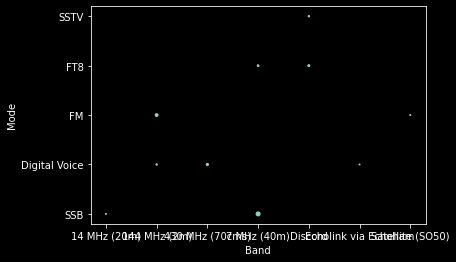

In [178]:
with pyplot.style.context(('dark_background')):
    bandmodeplot = dfcleanalised.groupby(['Band','Mode']).size().reset_index(name='count').plot.scatter(x='Band', y='Mode', s='count')

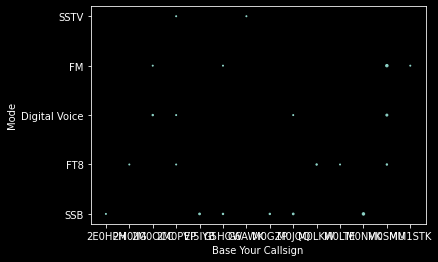

In [179]:
with pyplot.style.context(('dark_background')):
    callsignmodeplot = dfcleanalised.groupby(['Base Your Callsign','Mode']).size().reset_index(name='count').plot.scatter(x='Base Your Callsign', y='Mode', s='count')

## Mapping

This notebook uses ipyleaflet maps

In [180]:
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.204, 350.121),
    zoom=3
    )
m

Map(center=[48.204, 350.121], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [181]:
qth = []
locators = dfcleanalised['Locator Sent'].str.upper().unique()
for i in locators:
    if len(i)>3:
        qth.append([mh.to_location(i)[0],
                    mh.to_location(i)[1]])
Test_map = Map(basemap=basemaps.Stamen.Toner, center = [54, -2], zoom = 5)
list_of_markers = [Marker(location=x, draggable=False) for x in qth]
Test_map.add_layer(MarkerCluster(markers=list_of_markers))
Test_map.layout.height='700px'
Test_map
#print(locators)

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Lines to show QSOs

In [182]:
qsolines = []
dfqso = dfcleanalised[['Locator Sent', 'Locator Received']]
dfqso.drop_duplicates().values
lines = []
for row in dfqso.drop_duplicates().values:
    if len(row[0]) > 3:
        line = [[mh.to_location(row[0])[0],mh.to_location(row[0])[1]],[mh.to_location(row[1])[0],mh.to_location(row[1])[1]]]
        lines.append(line)
linelayer = Polyline(locations=lines, color="green", fill=False)
m = Map(basemap=basemaps.Stamen.Toner, center = (54, -2), zoom =5)
m.add_layer(linelayer)
m.layout.height='700px'
m

Map(center=[54, -2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

## Stats by day

### QSOs by day

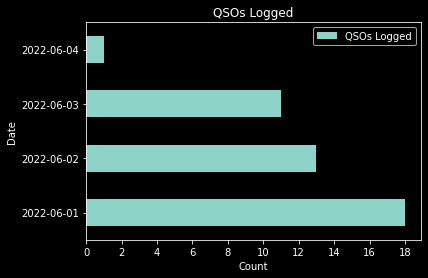

In [183]:
with pyplot.style.context(('dark_background')):
    daybyday = dfcleanalised[['UTC', 'Base Your Callsign']]
    daybyday = daybyday.set_index('UTC')
    daybyday = daybyday.groupby(daybyday.index.date)['Base Your Callsign'].count().plot.barh()
    daybyday.set_xlabel('Count')
    daybyday.set_title('QSOs Logged')
    daybyday.set_ylabel('Date')
    daybyday.xaxis.set_major_locator(MaxNLocator(integer=True))
    daybyday.legend(['QSOs Logged'])

### QSOs by Member by Day

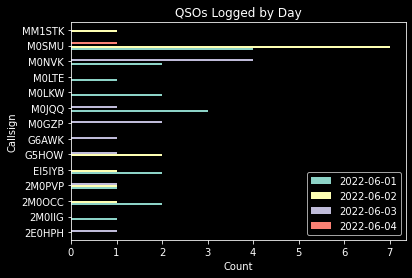

In [184]:
with pyplot.style.context(('dark_background')):
    daybyday = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    daybyday = daybyday.set_index('UTC')
    daybyday = daybyday.groupby(['Base Your Callsign', daybyday.index.date]).count()['Base Their Callsign'].unstack().plot.barh()
    daybyday.set_xlabel('Count')
    daybyday.set_title('QSOs Logged by Day')
    daybyday.set_ylabel('Callsign')
    daybyday.xaxis.set_major_locator(MaxNLocator(integer=True))

### Most QSOs in a day

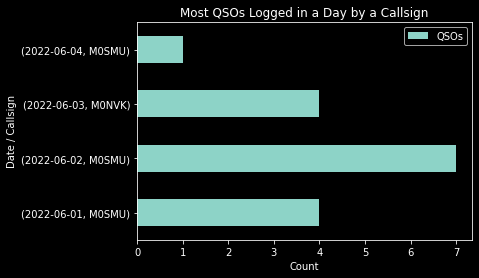

In [185]:
with pyplot.style.context(('dark_background')):
    qsomax = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    qsomax = qsomax.set_index('UTC')
    qsomax = qsomax.groupby([qsomax.index.date,'Base Your Callsign'])['Base Their Callsign'].count().unstack()#.plot.barh()
    qsomax = qsomax.idxmax(axis="columns")
    dayscores = dfcleanalised[['UTC', 'Base Your Callsign', 'Base Their Callsign']]
    dayscores = dayscores.set_index('UTC')
    dayscores = dayscores.groupby([dayscores.index.date, 'Base Your Callsign']).count()['Base Their Callsign']
    #dayscores = dayscores.index.str.split(',', expand=True)
    dayscores = dayscores.to_dict()
    dayplot = pd.DataFrame({'Date': [], 'Callsign': [], 'QSOs': []})
    for idx in qsomax.index:
        dayplot.loc[idx] = idx.isoformat(), qsomax[idx], dayscores[datetime.date.fromisoformat(str(idx)),qsomax[idx]]
    dayplot.set_index(['Date', 'Callsign'], inplace=True)
    dayplot = dayplot.plot.barh()
    dayplot.set_xlabel('Count')
    dayplot.set_title('Most QSOs Logged in a Day by a Callsign')
    dayplot.set_ylabel('Date / Callsign')
    dayplot.xaxis.set_major_locator(MaxNLocator(integer=True))